# Описание проекта
Оператор связи «Минифон» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OrdinalEncoder

import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter('ignore')

In [2]:
contract = pd.read_csv('C:/Users/erokh/Documents/contract.csv')
personal = pd.read_csv('C:/Users/erokh/Documents/personal.csv')
internet = pd.read_csv('C:/Users/erokh/Documents/internet.csv')
phone = pd.read_csv('C:/Users/erokh/Documents/phone.csv')

## Исследовательский анализ данных

Для определения дальнейшего плана действий изучим каждый датасет.

### Contract

In [3]:
contract.info()
display(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


Из первичной информации можно сделать следующие выводы:
1. Тип данных некоторых столбцов не соответствует ожидаемым (например, у столбца BeginDate тип данных "object", хотя должен быть datetime; столбцы MonthlyCharges и TotalCharges должны быть типа float). Также, вызывает вопросы столбец EndDate, где сочетаются категориальные данные и временные. Возможен перевод временных данных в категориальную и, как следствие, перевод столбца в бинарную переменную с типом данных int, где 0 - действующий клиент, 1 - клиент ушел.
2. Пропусков не замечено

In [4]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format = '%Y-%m-%d')
#столбец BeginDate перевед в тип данных datetime64

contract['MonthlyCharges'] = pd.to_numeric(contract['MonthlyCharges'], errors = 'coerce')
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors = 'coerce')

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


После изменения типа данных появились пропуски в TotalCharges

In [5]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [6]:
contract.loc[contract['TotalCharges'].isna(), 'TotalCharges'] = contract[contract['TotalCharges'].isna()]['MonthlyCharges']

Все клиенты, у кого присутствуют пропуски в столбце TotalCharges стали пользоваться услугами данной телеком компании в одно и то же время 2020-02-01. Можно предположить, что поскольку датой выгрузки как раз и является 1 февраля 2020 года, то информация о данных клиентах просто не успела обработаться. Поскольу договор уже заключен и оплата за первый месяц была совершена, то можно предположить, что общий доход с каждого клиента равен его месячному платежу.

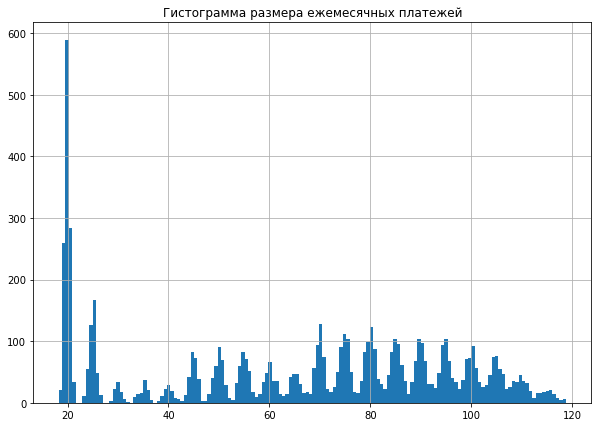

In [7]:
contract['MonthlyCharges'].hist(bins = 150, figsize = (10, 7))
plt.title('Гистограмма размера ежемесячных платежей')
plt.show()

In [8]:
contract['MonthlyCharges'].value_counts().head(50)

20.05    61
19.85    45
19.90    44
19.95    44
19.65    43
19.70    43
20.00    43
19.55    40
20.15    40
19.75    39
20.25    39
20.35    38
19.80    38
19.60    37
20.10    37
20.20    35
19.50    32
20.45    31
19.40    31
20.40    30
19.45    28
20.30    28
20.50    28
20.55    27
19.35    25
19.30    24
20.65    23
25.25    20
25.10    19
19.25    18
20.75    17
84.80    17
25.00    17
19.20    17
74.40    16
20.60    15
20.85    15
81.00    15
24.45    15
24.80    15
25.15    14
70.15    14
79.20    14
79.85    14
80.45    14
25.05    14
89.55    13
75.35    13
69.95    13
89.85    13
Name: MonthlyCharges, dtype: int64

При изучении гистограммы размера ежемесячных платежей можно заметить следующее:
1. Наиболее распространенный ежемесячный платже составляет приблизительно 20 у.е.
2. Заметны явные пики на кадом "круглой цифре". 20, 25, 30, 35, 40 и т.д. При этом в окрестностях каждого такого "круглого" размеры платежей распределены нормально. Можно сказать, что мы имеем множество нормальных распределений на каждом числе, которое заканчивается на 5 или 0.

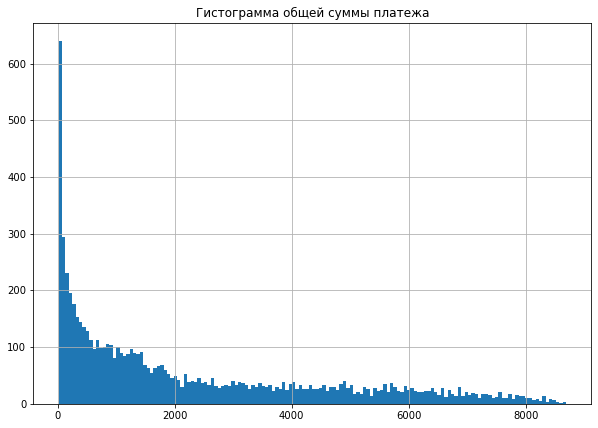

In [9]:
contract['TotalCharges'].hist(bins = 150, figsize = (10, 7))
plt.title('Гистограмма общей суммы платежа')
plt.show()

Большая часть клиентов имеют суммарный платеж не более 100 у.е. Причиной такого может быть большое количество новых клиентов, например. Исследуем далее время прихода клиентов для дачи более точной причины.

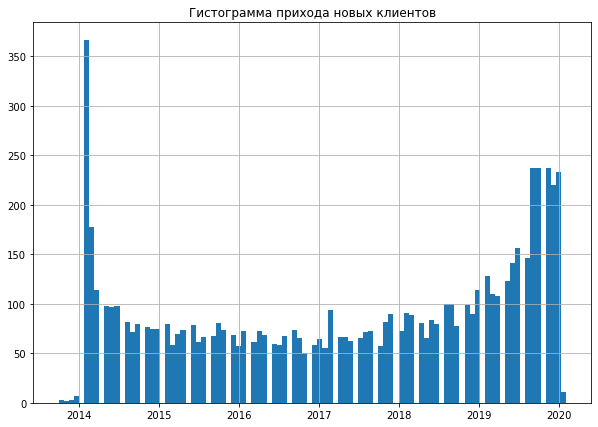

In [10]:
contract['BeginDate'].hist(bins = 100, figsize = (10, 7))
plt.title('Гистограмма прихода новых клиентов')
plt.show()

Исходя из гистограммы времени прихода клиентов в компанию, можем заметить, что:
1. Был огромный всплеск в 2014, но это может быть похоже на то, что компания только открылась, например.
2. С 2015 по 2019 было плато
3. С 2019 заметен возрастающий тренд. Компания начинает привлекать все больше клиентов.

Наше предположение о том, что большая часть клиентов платит не более 100 у.е. можно считать правдоподобным.

In [11]:
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

В столбце EndDate обнаружено всего 5 уникальных значений. Из того, что имеется можно сделать следующие выводы:
1. Компания имеет значительно больше активных клиентов, чем ушедших. 5174 активных против 1869 ушедших.
2. Клиенты начали уходить только в последние 4 месяца

Text(0.5, 1.0, 'Анализ ушедших клиентов. Гистограмма "старости" ушедшего клиента.')

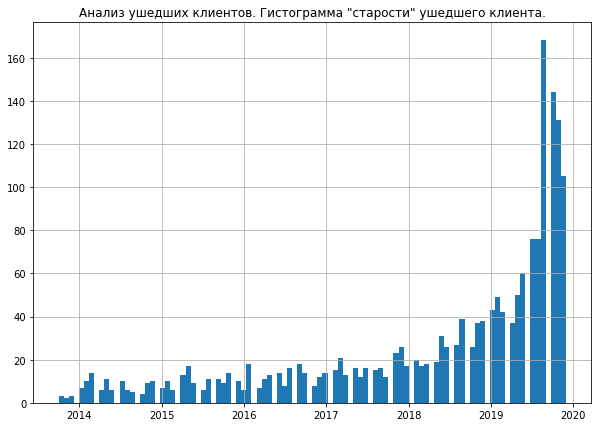

In [12]:
contract[contract['EndDate'] != 'No']['BeginDate'].hist(bins = 100, figsize = (10, 7))
plt.title('Анализ ушедших клиентов. Гистограмма "старости" ушедшего клиента.')

Для компании очень важно понимать портрет тех клиентов, которые уходят. Особенно важно, чтобы те, клиенты, которые с компанией уже давно продолжали оставаться с ней. На этой гистограмме можно посмотреть на распределение клиентов по времени, когда они стали клиентами данной компании. Как видим, больше всего из числа тех, кто перестал быть клиентом, новых клиентов, которые начали пользоваться услугами недавно.

In [13]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

У компании присутствует 3 типа договора. Ежемесячный платеж, годовой и двухгодичный контракт. Наиболее распространен помесячный.

In [14]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Компания принимает 4 вида платежа. Наиболее распространен электронный чек. Меньше всего востребована автоматическая оплата кредитной картой.

Посчитаем, сколько месяцев каждый человек являлся клиентом данной компании. Заодно создадим новый признак для будущей модели.

In [15]:
contract['New_EndDate'] = contract['EndDate']
#Продублируем столбец, чтобы не менять исходные данные

contract.loc[contract['New_EndDate'] == 'No', 'New_EndDate'] = pd.to_datetime('2020-02-01', format = '%Y-%m-%d')
#заменяем в новом столбце все значения, которые == 'No' на дату выгрузк данных

print(contract['New_EndDate'].value_counts()) #проверка

contract['New_EndDate'] = pd.to_datetime(contract['New_EndDate'], format = '%Y-%m-%d')
#меняем тип данных столбца

contract['Days_being_client'] =  ((contract['New_EndDate'] - contract['BeginDate'])/np.timedelta64(1, 'D')).astype('int')
#Считаем разницу в днях между датой, когда человек стал клиентом и датой, когда перестал им быть или же датой выгрузки, если он все еще явлется им

2020-02-01 00:00:00    5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: New_EndDate, dtype: int64


После того, как получили столбец с количеством месяцев, можно удалить столбец New_EndDate.

In [16]:
contract = contract.drop('New_EndDate', axis = 1)

### Personal

In [17]:
personal.info()
personal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [18]:
for el in personal.columns:
    print(personal[el].value_counts())
    print('------------------------------------')

2320-TZRRH    1
9546-KDTRB    1
6968-MHOMU    1
7018-FPXHH    1
8775-LHDJH    1
             ..
4332-MUOEZ    1
6124-ACRHJ    1
2905-KFQUV    1
0956-SYCWG    1
1090-PYKCI    1
Name: customerID, Length: 7043, dtype: int64
------------------------------------
Male      3555
Female    3488
Name: gender, dtype: int64
------------------------------------
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
------------------------------------
No     3641
Yes    3402
Name: Partner, dtype: int64
------------------------------------
No     4933
Yes    2110
Name: Dependents, dtype: int64
------------------------------------


Количество клиентов мужского пола и женского практически равно. Пенсионеры составляют 1/7 часть всех клиентов. Половина всех клиентов имеют партнера. 2/7 клиентов имеют кого то на иждивении. Аномалий не обнаружено.

In [19]:
personal_copy = personal.copy()

personal_copy.loc[personal['gender'] == 'Male', 'gender'] = 0
personal_copy.loc[personal['gender'] == 'Female', 'gender'] = 1

personal_copy.loc[personal['Partner'] == 'No', 'Partner'] = 0
personal_copy.loc[personal['Partner'] == 'Yes', 'Partner'] = 1

personal_copy.loc[personal['Dependents'] == 'No', 'Dependents'] = 0
personal_copy.loc[personal['Dependents'] == 'Yes', 'Dependents'] = 1

In [20]:
personal_corr = personal_copy.drop('customerID', axis = 1).copy()
personal_corr[['gender', 'SeniorCitizen', 'Partner', 'Dependents']] = personal_corr[['gender', 'SeniorCitizen', 'Partner', 'Dependents']].astype('Int64')
personal_corr.corr()

,gender,SeniorCitizen,Partner,Dependents
gender,1.000000,0.001874,0.001808,-0.010517
SeniorCitizen,0.001874,1.000000,0.016479,-0.211185
Partner,0.001808,0.016479,1.000000,0.452676
Dependents,-0.010517,-0.211185,0.452676,1.000000


Для оценки корреляции перевели категориальные столбцы в численные. Есть средняя корреляция между наличием у человека партнера и наличием у них кого то на иждивении. Можно предположить, что эти клиенты, например, родители.

### Internet

In [21]:
internet.info()
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [22]:
for el in internet.columns:
    print(internet[el].value_counts())
    print('------------------------------------')

8582-KRHPJ    1
5377-NDTOU    1
4525-VZCZG    1
4118-CEVPF    1
0739-UUAJR    1
             ..
9206-GVPEQ    1
0744-GKNGE    1
5161-UBZXI    1
2858-EIMXH    1
1090-PYKCI    1
Name: customerID, Length: 5517, dtype: int64
------------------------------------
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64
------------------------------------
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
------------------------------------
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
------------------------------------
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
------------------------------------
No     3473
Yes    2044
Name: TechSupport, dtype: int64
------------------------------------
No     2810
Yes    2707
Name: StreamingTV, dtype: int64
------------------------------------
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64
------------------------------------


Большинство клиентов имеют оптоволоконное подключение (3096 из 5517). Посмотрим, отличаются ли подключенные сервисы в зависимости от типа интернета (оптоволокно или DSL).

In [23]:
for el in internet[internet['InternetService'] == 'Fiber optic'].columns:
    print(internet[internet['InternetService'] == 'Fiber optic'][el].value_counts())
    print('------------------------------------')


7668-XCFYV    1
9432-RUVSL    1
4521-YEEHE    1
8380-PEFPE    1
4692-NNQRU    1
             ..
9512-UIBFX    1
4735-ASGMA    1
3584-WKTTW    1
1334-PDUKM    1
1090-PYKCI    1
Name: customerID, Length: 3096, dtype: int64
------------------------------------
Fiber optic    3096
Name: InternetService, dtype: int64
------------------------------------
No     2257
Yes     839
Name: OnlineSecurity, dtype: int64
------------------------------------
No     1753
Yes    1343
Name: OnlineBackup, dtype: int64
------------------------------------
No     1739
Yes    1357
Name: DeviceProtection, dtype: int64
------------------------------------
No     2230
Yes     866
Name: TechSupport, dtype: int64
------------------------------------
Yes    1750
No     1346
Name: StreamingTV, dtype: int64
------------------------------------
Yes    1751
No     1345
Name: StreamingMovies, dtype: int64
------------------------------------


In [24]:
for el in internet[internet['InternetService'] == 'DSL'].columns:
    print(internet[internet['InternetService'] == 'DSL'][el].value_counts())
    print('------------------------------------')

3351-NGXYI    1
4816-JBHOV    1
5172-MIGPM    1
7191-ADRGF    1
4349-GFQHK    1
             ..
7131-ZQZNK    1
1136-XGEQU    1
4310-KEDTB    1
2511-MORQY    1
8822-KNBHV    1
Name: customerID, Length: 2421, dtype: int64
------------------------------------
DSL    2421
Name: InternetService, dtype: int64
------------------------------------
No     1241
Yes    1180
Name: OnlineSecurity, dtype: int64
------------------------------------
No     1335
Yes    1086
Name: OnlineBackup, dtype: int64
------------------------------------
No     1356
Yes    1065
Name: DeviceProtection, dtype: int64
------------------------------------
No     1243
Yes    1178
Name: TechSupport, dtype: int64
------------------------------------
No     1464
Yes     957
Name: StreamingTV, dtype: int64
------------------------------------
No     1440
Yes     981
Name: StreamingMovies, dtype: int64
------------------------------------


Можно сделать следующие выводы:
1. OnlineSecurity. Процент пользователей функцией OnlineSecurity (48.7%) среди пользователей с DSL значительно выше, чем пользователей с оптоволокном (27%).
2. OnlineBackup. Данной функцией пользуются одинаково.
3. DeviceProtection. Данной функцией пользуются одинаково.
4. TechSupport. Данной функцией чаще пользуются пользователи с DSL (присутствует у 48.6% клиентов с DSL, у всего у 27.9% клиентов с оптоволокном). 
5. StreamingTV. Пользователи с DSL: 39.5%. Пользователи с оптоволокном: 56.5%.
6. StreamingMovies. Пользователи с DSL: 40.5%. Пользователи с оптоволокном: 56.5%.

Большинство различий можно связать с особенностями каждого типа подключения. Оптоволокно - более современный тип подключения с более высокими скоростями. Поэтому не удивительно видеть более высокие проценты подписок на стриминговые сервисы по сравнению с пользователя DSL.

### Phone

In [25]:
phone.info()
phone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Аномалий не обнурежно. Типа данных столбцов соответствуют их содержанию.

In [26]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

46.7% клиентов имеют возможность ведения параллельных линий во время звонка.

## Вывод исследовательского анализа данных

In [27]:
len(contract), len(personal), len(internet), len(phone)

(7043, 7043, 5517, 6361)

Был проанлизирован и изучен каждый документ. На основе данного анализа можно сделать следующие выводы:
1. В таблицах присутствует большое количество разнообразных типов данных. Для дальнейшего построения модели машинного обучение будет необходимо применять кодирование.
2. Присутствует значимый дисбаланс в классах в предсказуемой переменной ```contract['EndDate']```. Поэтому, возможно будет актуально применять инструменты для балансировки (upsampling / downsampling).
3. Был создан один дополнительный признак.
4. Количество строк в таблицах различается. Что говорит о том, что каким то клиентам оказывается не весь пакет услуг, а что то одно (либо интернет, либо телефония).

## Подготовка данных для обучения модели

Попробуем объединить все таблицы, провести кодировку категориальных переменных и обучить модель. Перед объединением добавим бинарные переменные(1;0) в таблицы internet и phone, которые будут выделять тех клиентов, которые пользуется этими сервисами.

In [28]:
internet['internet_client'] = 'Yes'
phone['phone_client'] = 'Yes'

Далее объединим все таблицы в одну.

In [29]:
contract_personal = contract.merge(personal, on = 'customerID')
contract_personal_internet = contract_personal.merge(internet, on = 'customerID', how = 'outer')
full_data = contract_personal_internet.merge(phone, on = 'customerID', how = 'outer')

In [30]:
full_data.isna().sum()

customerID              0
BeginDate               0
EndDate                 0
Type                    0
PaperlessBilling        0
PaymentMethod           0
MonthlyCharges          0
TotalCharges            0
Days_being_client       0
gender                  0
SeniorCitizen           0
Partner                 0
Dependents              0
InternetService      1526
OnlineSecurity       1526
OnlineBackup         1526
DeviceProtection     1526
TechSupport          1526
StreamingTV          1526
StreamingMovies      1526
internet_client      1526
MultipleLines         682
phone_client          682
dtype: int64

Поскольку таблицы internet и phone имеют разные длины по сравнению с таблицей contract, где содержаться все клиенты, то таблицы internet и phone были присоединины методом outer. Соответственно, у тех клиентов, которые не пользовались интернетом или телефонией данной компании появились пропуски.

In [31]:
full_data = full_data.fillna('None')
full_data.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
Days_being_client    0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
internet_client      0
MultipleLines        0
phone_client         0
dtype: int64

Заполняем все пропущенные значения новой категорией 'None'. Итого, на данный момент клиенты делятся на три категории:
1. Yes. Клиент является клиентом компании, пользуется данным сервисом (интернет или телефония) и использует ту или иную технологию внутри выбранного сервиса.
2. No. Клиент не пользуется данным сервисом. Клиент пользуется сервисом, но не выбранной технологией внутри выбранного сервиса.
3. None. Клиент в принципе не использует данный сервис.

Далее закодируем категориальные данные разными кодировщиками, чтобы в дальнейшем оценить эффективность каждого и выбрать наилучший. Однако перед этим избавимся от столбца customerID, поскольку никакой информации о клиенте он в себе не несет, переведем столбец EndDate в бинарную переменную, а также удалим столбец BeginDate, поскольку в сочетании с признаком Months_being_client это может привести к утечки данных.

In [32]:
full_data = full_data.drop(['customerID', 'BeginDate'], axis = 1)

In [33]:
full_data.loc[full_data['EndDate'] != 'No', 'EndDate'] = 1
full_data.loc[full_data['EndDate'] == 'No', 'EndDate'] = 0

### OrdinalEncoder

In [34]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(full_data), columns = full_data.columns)
data_ordinal.info()
data_ordinal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EndDate            7043 non-null   float64
 1   Type               7043 non-null   float64
 2   PaperlessBilling   7043 non-null   float64
 3   PaymentMethod      7043 non-null   float64
 4   MonthlyCharges     7043 non-null   float64
 5   TotalCharges       7043 non-null   float64
 6   Days_being_client  7043 non-null   float64
 7   gender             7043 non-null   float64
 8   SeniorCitizen      7043 non-null   float64
 9   Partner            7043 non-null   float64
 10  Dependents         7043 non-null   float64
 11  InternetService    7043 non-null   float64
 12  OnlineSecurity     7043 non-null   float64
 13  OnlineBackup       7043 non-null   float64
 14  DeviceProtection   7043 non-null   float64
 15  TechSupport        7043 non-null   float64
 16  StreamingTV        7043 

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Days_being_client,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet_client,MultipleLines,phone_client
0,0.0,0.0,1.0,2.0,142.0,74.0,2.0,0.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,3.0,498.0,3628.0,74.0,1.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,3.0,436.0,540.0,3.0,1.0,0.0,0.0,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,266.0,3574.0,96.0,1.0,0.0,0.0,...,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0
4,1.0,0.0,1.0,2.0,729.0,678.0,3.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.0,1.0,1.0,3.0,991.0,3704.0,52.0,1.0,0.0,1.0,...,0.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0
7039,0.0,1.0,1.0,1.0,1340.0,6308.0,155.0,0.0,0.0,1.0,...,1.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,1.0
7040,0.0,0.0,1.0,2.0,137.0,1269.0,25.0,0.0,0.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7041,1.0,0.0,1.0,3.0,795.0,1161.0,8.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0


### One-Hot Encoding

In [35]:
data_OHE = pd.get_dummies(full_data, drop_first = True)
data_OHE.info()
data_OHE

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7043 non-null   float64
 1   TotalCharges                           7043 non-null   float64
 2   Days_being_client                      7043 non-null   int32  
 3   SeniorCitizen                          7043 non-null   int64  
 4   EndDate_1                              7043 non-null   uint8  
 5   Type_One year                          7043 non-null   uint8  
 6   Type_Two year                          7043 non-null   uint8  
 7   PaperlessBilling_Yes                   7043 non-null   uint8  
 8   PaymentMethod_Credit card (automatic)  7043 non-null   uint8  
 9   PaymentMethod_Electronic check         7043 non-null   uint8  
 10  PaymentMethod_Mailed check             7043 non-null   uint8  
 11  gend

,MonthlyCharges,TotalCharges,Days_being_client,SeniorCitizen,EndDate_1,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,TechSupport_None,TechSupport_Yes,StreamingTV_None,StreamingTV_Yes,StreamingMovies_None,StreamingMovies_Yes,internet_client_Yes,MultipleLines_None,MultipleLines_Yes,phone_client_Yes
0,29.85,29.85,31,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,1,0,0
1,56.95,1889.50,1036,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,53.85,108.15,61,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,42.30,1840.75,1371,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
4,70.70,151.65,61,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,1990.50,730,0,0,1,0,1,0,0,...,0,1,0,1,0,1,1,0,1,1
7039,103.20,7362.90,2191,0,0,1,0,1,1,0,...,0,0,0,1,0,1,1,0,1,1
7040,29.60,346.45,337,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,1,0,0
7041,74.40,306.60,123,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,1


### Подготовка обучающего и тестового датасетов

In [36]:
#OrdinalEncoder
features_ordinal = data_ordinal.drop(['EndDate'], axis = 1)
target_ordinal = data_ordinal['EndDate']

features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test = train_test_split(features_ordinal, target_ordinal, test_size = .2, random_state = 123)


#OHE
features_OHE = data_OHE.drop(['EndDate_1'], axis = 1)
target_OHE = data_OHE['EndDate_1']

features_OHE_train, features_OHE_test, target_OHE_train, target_OHE_test = train_test_split(features_OHE, target_OHE, test_size = .2, random_state = 123)


### Дисбаланс классов

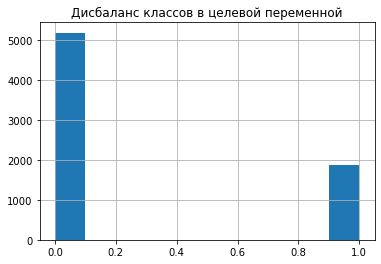

In [37]:
full_data['EndDate'].hist()
plt.title('Дисбаланс классов в целевой переменной')
plt.show()

Для борьбы с дисбалансом попробуем следующие техники:
1. Upsampling
2. Downsampling
3. Соответствующие гиперпараметры у моделей

### Upsampling

In [38]:
full_data['EndDate'].value_counts()

0    5174
1    1869
Name: EndDate, dtype: int64

In [39]:
ones_multiplier = round(len(full_data) // len(full_data.loc[full_data['EndDate'] == 1, 'EndDate']), 1)
ones_multiplier

3

Для уравновешивания классов необходимо домножить класс с таргетом "1" на 3.

In [40]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [41]:
features_train_upsampled_OHE, target_train_upsampled_OHE = upsample(features_OHE_train, target_OHE_train, 4)

len(features_train_upsampled_OHE), len(target_train_upsampled_OHE)#, len(features_test_upsampled_OHE), len(target_test_upsampled_OHE)

(10059, 10059)

In [42]:
features_train_upsampled_ordinal, target_train_upsampled_ordinal = upsample(features_ordinal_train, target_ordinal_train, 4)

len(features_train_upsampled_ordinal), len(target_train_upsampled_ordinal)#, len(features_test_upsampled_ordinal), len(target_test_upsampled_ordinal)

(10059, 10059)

### Downsampling

In [43]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [44]:
features_train_downsampled_OHE, target_train_downsampled_OHE = downsample(features_OHE_train, target_OHE_train, .3)

In [45]:
features_train_downsampled_ordinal, target_train_downsampled_ordinal = downsample(features_ordinal_train, target_ordinal_train, .3)

### Обучение моделей
После того, как была проведена предобрабокта данных можно перейти к обучению моделей. Для обучения возьмем следующие модели:
1. Random forest
2. Lgbm
3. XGBoost
4. CatBoost
5. Logistic Regression

#### Random forest

In [46]:
max_depth = 0
best_est = 0
best_model = None
S = 0
for est in range (70, 150):
    for depth in range (7, 12):
        model_balanced = RandomForestClassifier(random_state = 1, n_estimators = est, max_depth = depth)
        model_balanced.fit(features_train_upsampled_OHE, target_train_upsampled_OHE)
        predictions = model_balanced.predict(features_OHE_test)
        probabilities_RF = model_balanced.predict_proba(features_OHE_test)
        probabilities_one_RF = probabilities_RF[:, 1]
        s = roc_auc_score(target_OHE_test, probabilities_one_RF)
        if s > S:
            S = s
            max_depth = depth
            best_model = model_balanced
            best_est = est
    
print('max depth', max_depth)
print('best_est:', best_est)
print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc_score(target_OHE_test, probabilities_one_RF)))

max depth 8
best_est: 99
Площадь под ROC-кривой: 0.86


In [47]:
def random_forest(X_train, X_test, y_train, y_test):
    model = best_model
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one)
    
    print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc))
    print('Accuracy:', round(accuracy, 2))
    return round(accuracy, 3), round(roc_auc, 3)

In [48]:
rf_up_OHE = random_forest(features_train_upsampled_OHE, features_OHE_test, target_train_upsampled_OHE, target_OHE_test)

Площадь под ROC-кривой: 0.87
Accuracy: 0.73


In [49]:
rf_ORD = random_forest(features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test)

Площадь под ROC-кривой: 0.87
Accuracy: 0.81


In [50]:
rf_up_ORD = random_forest(features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.86
Accuracy: 0.75


In [51]:
rf_down_OHE = random_forest(features_train_downsampled_OHE, features_OHE_test, target_train_downsampled_OHE, target_OHE_test)

Площадь под ROC-кривой: 0.86
Accuracy: 0.74


In [52]:
rf_down_ORD = random_forest(features_train_downsampled_ordinal, features_ordinal_test, target_train_downsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.86
Accuracy: 0.75


#### Lgbm

In [53]:
def lgbm(X_train, X_test, y_train, y_test):
    model = lgb.LGBMClassifier()
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one)
    
    print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc))
    print('Accuracy:', round(accuracy, 2))
    return round(accuracy, 3), round(roc_auc, 3)

In [54]:
lgbm_up_OHE = lgbm(features_train_upsampled_OHE, features_OHE_test, target_train_upsampled_OHE, target_OHE_test)

Площадь под ROC-кривой: 0.92
Accuracy: 0.83


In [55]:
lgbm_ORD = lgbm(features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test)

Площадь под ROC-кривой: 0.91
Accuracy: 0.85


In [56]:
lgbm_up_ORD = lgbm(features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.92
Accuracy: 0.83


In [57]:
lgbm_down_OHE = lgbm(features_train_downsampled_OHE, features_OHE_test, target_train_downsampled_OHE, target_OHE_test)


Площадь под ROC-кривой: 0.89
Accuracy: 0.79


In [58]:
lgbm_down_ORD = lgbm(features_train_downsampled_ordinal, features_ordinal_test, target_train_downsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.89
Accuracy: 0.79


#### XGBoost

In [59]:
def XGBoost_model(X_train, X_test, y_train, y_test):
    model = XGBClassifier(iterations=100, verbose = 0)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one)
    
    print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc))
    print('Accuracy:', round(accuracy, 2))
    return round(accuracy, 3), round(roc_auc, 3)

In [60]:
XGB_up_OHE = XGBoost_model(features_train_upsampled_OHE, features_OHE_test, target_train_upsampled_OHE, target_OHE_test)


[00:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "iterations", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Площадь под ROC-кривой: 0.90
Accuracy: 0.84


In [61]:
XGB_ORD = XGBoost_model(features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test)


[00:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "iterations", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Площадь под ROC-кривой: 0.91
Accuracy: 0.86


In [62]:
XGB_up_ORD = XGBoost_model(features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test)


[00:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "iterations", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Площадь под ROC-кривой: 0.91
Accuracy: 0.84


In [63]:
XGB_down_OHE = XGBoost_model(features_train_downsampled_OHE, features_OHE_test, target_train_downsampled_OHE, target_OHE_test)


[00:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "iterations", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Площадь под ROC-кривой: 0.89
Accuracy: 0.8


In [64]:
XGB_down_ORD = XGBoost_model(features_train_downsampled_ordinal, features_ordinal_test, target_train_downsampled_ordinal, target_ordinal_test)

[00:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "iterations", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:02:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Площадь под ROC-кривой: 0.89
Accuracy: 0.79


#### CatBoost

In [65]:
def CatBoost_model(X_train, X_test, y_train, y_test):
    model = CatBoostClassifier(eval_metric='AUC', iterations=500, verbose = 500)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one)
    
    print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc))
    print('Accuracy:', round(accuracy, 2))
    return round(accuracy, 3), round(roc_auc, 3)

In [66]:
cb_up_OHE = CatBoost_model(features_train_upsampled_OHE, features_OHE_test, target_train_upsampled_OHE, target_OHE_test)

Learning rate set to 0.052128
0:	total: 170ms	remaining: 1m 24s
499:	total: 6.51s	remaining: 0us
Площадь под ROC-кривой: 0.91
Accuracy: 0.82


In [67]:
cb_ORD = CatBoost_model(features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test)

Learning rate set to 0.040698
0:	total: 3.45ms	remaining: 1.72s
499:	total: 1.41s	remaining: 0us
Площадь под ROC-кривой: 0.90
Accuracy: 0.86


In [68]:
cb_up_ORD = CatBoost_model(features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test)


Learning rate set to 0.052128
0:	total: 5.69ms	remaining: 2.84s
499:	total: 2.28s	remaining: 0us
Площадь под ROC-кривой: 0.90
Accuracy: 0.83


In [69]:
cb_down_OHE = CatBoost_model(features_train_downsampled_OHE, features_OHE_test, target_train_downsampled_OHE, target_OHE_test)

Learning rate set to 0.029836
0:	total: 2.8ms	remaining: 1.4s
499:	total: 3.58s	remaining: 0us
Площадь под ROC-кривой: 0.88
Accuracy: 0.77


In [70]:
cb_down_ORD = CatBoost_model(features_train_downsampled_ordinal, features_ordinal_test, target_train_downsampled_ordinal, target_ordinal_test)

Learning rate set to 0.029836
0:	total: 15.9ms	remaining: 7.96s
499:	total: 1.11s	remaining: 0us
Площадь под ROC-кривой: 0.88
Accuracy: 0.77


#### Logistic regression

In [71]:
def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression(class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    probabilities = model.predict_proba(X_test)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities_one)
    
    print('Площадь под ROC-кривой: {:.2f}'.format(roc_auc))
    print('Accuracy:', round(accuracy, 2))
    return round(accuracy, 3), round(roc_auc, 3)

In [72]:
lg_up_OHE = logistic_regression(features_train_upsampled_OHE, features_OHE_test, target_train_upsampled_OHE, target_OHE_test)

Площадь под ROC-кривой: 0.85
Accuracy: 0.76


In [73]:
lg_ORD = logistic_regression(features_ordinal_train, features_ordinal_test, target_ordinal_train, target_ordinal_test)

Площадь под ROC-кривой: 0.85
Accuracy: 0.75


In [74]:
lg_up_ORD = logistic_regression(features_train_upsampled_ordinal, features_ordinal_test, target_train_upsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.85
Accuracy: 0.75


In [75]:
lg_dwon_OHE = logistic_regression(features_train_downsampled_OHE, features_OHE_test, target_train_downsampled_OHE, target_OHE_test)

Площадь под ROC-кривой: 0.85
Accuracy: 0.76


In [76]:
lg_dwon_ORD = logistic_regression(features_train_downsampled_ordinal, features_ordinal_test, target_train_downsampled_ordinal, target_ordinal_test)

Площадь под ROC-кривой: 0.85
Accuracy: 0.76


## Выводы

In [77]:
columns = ['AUC_ROC', 'Accuracy']

rf_ACC = rf_up_OHE[0], rf_ORD[0], rf_up_ORD[0], rf_down_OHE[0], rf_down_ORD[0]
rf_AUC = rf_up_OHE[1], rf_ORD[1], rf_up_ORD[1], rf_down_OHE[1], rf_down_ORD[1]

lgbm_ACC = lgbm_up_OHE[0], lgbm_ORD[0], lgbm_up_ORD[0], lgbm_down_OHE[0], lgbm_down_ORD[0]
lgbm_AUC = lgbm_up_OHE[1], lgbm_ORD[1], lgbm_up_ORD[1], lgbm_down_OHE[1], lgbm_down_ORD[1]

xgboost_ACC = XGB_up_OHE[0], XGB_ORD[0], XGB_up_ORD[0], XGB_down_OHE[0], XGB_down_ORD[0]
xgboost_AUC = XGB_up_OHE[1], XGB_ORD[1], XGB_up_ORD[1], XGB_down_OHE[1], XGB_down_ORD[1]

cb_ACC = cb_up_OHE[0], cb_ORD[0], cb_up_ORD[0], cb_down_OHE[0], cb_down_ORD[0]
cb_AUC = cb_up_OHE[1], cb_ORD[1], cb_up_ORD[1], cb_down_OHE[1], cb_down_ORD[1]

lr_ACC = lg_up_OHE[0], lg_ORD[0], lg_up_ORD[0], lg_dwon_OHE[0], lg_dwon_ORD[0]
lr_AUC = lg_up_OHE[1], lg_ORD[1], lg_up_ORD[1], lg_dwon_OHE[1], lg_dwon_ORD[1]

In [78]:
accuracy = list(sum([rf_ACC, lgbm_ACC, xgboost_ACC, cb_ACC, lr_ACC], ()))
auc_roc = list(sum([rf_AUC, lgbm_AUC, xgboost_AUC, cb_AUC, lr_AUC], ()))

In [79]:
results = pd.DataFrame(data = accuracy, columns = ['Accuracy'])
results['AUC_ROC'] = auc_roc
index = ['rf_up_OHE', 'rf_ORD', 'rf_up_ORD', 'rf_down_OHE', 'rf_down_ORD', 'lgbm_up_OHE', 'lgbm_ORD', 'lgbm_up_ORD', \
         'lgbm_down_OHE', 'lgbm_down_ORD', 'XGB_up_OHE', 'XGB_ORD', 'XGB_up_ORD', 'XGB_down_OHE', 'XGB_down_ORD', \
         'cb_up_OHE', 'cb_ORD', 'cb_up_ORD', 'cb_down_OHE', 'cb_down_ORD', 'lg_up_OHE', 'lg_ORD', 'lg_up_ORD', \
         'lg_dwon_OHE', 'lg_dwon_ORD']
results.index = index

In [80]:
results.sort_values('AUC_ROC', ascending = False)

,Accuracy,AUC_ROC
lgbm_up_OHE,0.834,0.916
lgbm_up_ORD,0.830,0.916
XGB_ORD,0.861,0.915
XGB_up_ORD,0.841,0.909
cb_up_OHE,0.822,0.906
lgbm_ORD,0.855,0.906
cb_up_ORD,0.828,0.905
XGB_up_OHE,0.838,0.904
cb_ORD,0.860,0.904
lgbm_down_OHE,0.792,0.893


За основу были взяты 5 моделей (Random forest, Lgbm, XGBoost, CatBoost, Logistic regression). Затем рассматривались показатели каждой модели в разных условиях:
1. Менялся кодировщик (OHE, Ordinal)
2. Менялся способ борьбы с дисбалансом (Upsampling, Downsampling)
3. Оригинальные данные без борьбы с дисбалансом

В качестве основной целевой метрики использовался ROC AUC и в качестве дополнительной accuracy. Итого, получилось 25 моделей. Наилучший основной скор получилось достичь сразу 2 моделям: lgbm с OHE и upsampling (0.916), а также lgbm с ordinal encoder и upsampling (0.916). Однако, с учетом дополнительной метрики (accuracy) на первое место выходит lgbm с OHE и upsampling с accuracy = 0.834, что на всего 0.004 больше, чем у второй модели lgbm с ordinal encoder и upsampling (0.830).